In [1]:
#借助 Intel(R) Extension for Scikit-learn，您可以加速您的 Scikit-learn 应用程序，并且仍然完全符合所有 Scikit-Learn API 和算法。这是一款免费软件 AI 加速器，可为各种应用带来超过10-100 倍的加速。而且您甚至不需要更改现有代码！
# !python -m pip install pandas matplotlib scikit-learn-intelex scikit-learn openpyxl tensorboard seaborn ipykernel ipywidgets keras plotly plotly_express
# !python -m pip install  tensorflow==2.15.*
# !python -m pip install  tensorflow[and-cuda]==2.15.*
#


In [2]:
# 本导入顺序可以看到类型
import tensorflow as tf
import keras
# import tensorflow_datasets as tfds
import datetime
import os
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
from sklearn import preprocessing as skl
from sklearn.model_selection import train_test_split

# from tensorflow import keras

from keras import layers
from keras import models



patch_sklearn()
# from attention_utils import get_activations

#更好地兼容 Python 3 的行为和特性，使得代码可以在 Python 2 和 Python 3 下运行得更加一致
# from __future__ import absolute_import,division,print_function,unicode_literals
from matplotlib import pyplot as plt
from matplotlib import ticker as mt
# 或者直接指定字体文件路径
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans Mono']  # 系统自带的黑体
plt.rcParams['font.serif'] = ['SimHei']  # 系统自带的宋体
plt.rcParams['font.family'] = [
    'SimHei',
    'DejaVu Sans Mono',  # 显示负号的字体
    # 'Liberation Mono',
    'Consolas',
    'Courier New',
    'monospace',
    'sans-serif',
    'serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
    'sans-serif',
    'sans',
    'serif',
]
plt.rcParams['axes.unicode_minus'] = False  # 设置matplotlib显示正常的负号而非减号样式

2024-04-22 02:58:05.258472: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 02:58:05.278524: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 02:58:05.278547: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 02:58:05.279086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 02:58:05.282600: I tensorflow/core/platform/cpu_feature_guar

In [3]:
print(' ')
print(f'{datetime.datetime.now()} tensorflow版本:', tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")
print(' ')
print('gpus： ')
print(gpus)
print(' ')
print('gpus')
# 查看系统中可见的GPU设备
print("Available GPU devices:", tf.config.list_physical_devices("GPU"))


 
2024-04-22 02:58:06.646928 tensorflow版本: 2.15.1
 
gpus： 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
 
gpus
Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-22 02:58:06.762547: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 02:58:06.777055: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 02:58:06.777093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# # 读取数据

from load_data import load_fixed_data, categories

R_CREATE = False
R_CREATE = True


def create_dynamic_globals(dyn_name, value, global_vars, read_cache: bool = True):
    """
    :param dyn_name: 动态变量名
    :param value: 动态变量值
    :param global_vars: 全局变量字典
    :return:
    """
    # print(dyn_name, global_vars[dyn_name])
    if read_cache and (R_CREATE or dyn_name not in global_vars or global_vars[dyn_name] == None):
        # 如果确实需要在全局作用域创建真正的全局变量，可以使用exec，但这不是推荐做法
        if callable(value):

            v = value(dyn_name)
            s = f'global {dyn_name}; {dyn_name} = v'
            # print(s)
            exec(s)
        else:
            exec(f'global {dyn_name}; {dyn_name} = {value}')

    return globals()[dyn_name]


def create_global_vars(global_vars, varprefix: str = 'data_', read_cache: bool = True):

    for gvar in global_vars:
        #
        if gvar.startswith('_'):
            continue
        if gvar.startswith(varprefix):
            print(gvar, )
            create_dynamic_globals(gvar, lambda f: load_fixed_data(f'./data/{f}.xlsx'), global_vars)


data_17 = pd.DataFrame()
data_21 = data_17
data_22 = data_17
data_23 = data_17
data_24 = data_17

create_global_vars(globals(), varprefix='data_')

# data_17.dtypes

data_17
data_21
data_22
data_23
data_24


In [5]:
from libs.config import *

In [6]:
#组合数据集
from load_data import categories

numeric_col_names = [
    '原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x', 'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff', 'su_ad_diff', 'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff', 'su_y_diff', 'su_z_diff', '速度', '估计重量'
]

# delete some
# ['Unnamed: 0' ,
# 'label'      , '时间'         , '轨迹时间'       , '速度',, '估计重量'
# '原始重量'       , '稳定重量'       , '轴重'         , 'su_ad',
# '原始重量_diff'  , '稳定重量_diff'  , '轴重_diff'    , 'su_ad_diff',
# 'wpu_x'      , 'wpu_y'      , 'wpu_z'      ,
# 'wpu_x_diff' , 'wpu_y_diff' , 'wpu_z_diff',
# 'su_x'       , 'su_y'       , 'su_z'       ,
# 'su_x_diff'  , 'su_y_diff'  , 'su_z_diff'
# ]
label_col_names = ["label"]
time_col_names = ["时间", "轨迹时间"]



all_col_names = numeric_col_names + label_col_names + time_col_names
df17, df21, df22, df23, df24 = data_17[all_col_names], data_21[all_col_names], data_22[all_col_names], data_23[all_col_names], data_24[all_col_names]
origindata = pd.concat([df17, df21, df22, df23, df24], axis=0, ignore_index=True)

# print(origindata.columns)

print(origindata.shape, origindata.columns, origindata.dtypes)

(107420, 25) Index(['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x',
       'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff', 'su_ad_diff',
       'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff', 'su_y_diff',
       'su_z_diff', '速度', '估计重量', 'label', '时间', '轨迹时间'],
      dtype='object') 原始重量                   int64
稳定重量                   int64
轴重                     int64
su_ad                  int64
wpu_x                  int64
wpu_y                  int64
wpu_z                  int64
su_x                   int64
su_y                   int64
su_z                   int64
原始重量_diff              int64
稳定重量_diff              int64
轴重_diff                int64
su_ad_diff             int64
wpu_x_diff             int64
wpu_y_diff             int64
wpu_z_diff             int64
su_x_diff              int64
su_y_diff              int64
su_z_diff              int64
速度                   float64
估计重量                 float64
label                  int64
时间            date

In [7]:
# check 数据集有缺失值
shapea= origindata.shape
df = origindata.dropna()
shapeb =df.shape
print(shapea, shapeb)
if shapea != shapeb:
    print(shapea,shapeb)
    ValueError("数据集有缺失值")

# missing_values

(107420, 25) (107420, 25)


In [8]:

def windowed_dataset(dataset: tf.data.Dataset, window_size=5, shift=1, stride=1):
    windows = dataset.window(window_size, shift=shift, stride=stride, drop_remainder=True)

    def sub_to_batch(t1, t2=None):
        t1_batches = t1.batch(window_size, drop_remainder=True)

        if t2 is not None:
            t2_batches = t2.batch(window_size, drop_remainder=True)
            return tf.data.Dataset.zip(t1_batches, t2_batches)
        else:
            return t1_batches

    windows = windows.flat_map(sub_to_batch)
    return windows


from turtle import up
import scipy
from scipy.stats import iqr

p = 1.5


def replace_iqr_outliers(df: pd.DataFrame, colums: list[str]):
    q = 0.25
    _df = df.copy()
    for column in colums:
        _df[column] = _df[column].astype(float)
        q1 = _df[column].quantile(q)  #.quantile(0.25)
        q3 = _df[column].quantile(1 - q)  #.quantile(0.75)
        iqr_value = iqr(_df[column], rng=(q * 100, (1 - q) * 100))
        print('------', iqr_value)

        lower_bound = q1 - p * iqr_value
        upper_bound = q3 + p * iqr_value
        _df.loc[_df[column] < lower_bound, column] = lower_bound
        _df.loc[_df[column] > upper_bound, column] = upper_bound

    return _df

In [9]:
# 准备数据
# 使用Savitzky-Golay 滤波器后得到平滑图线
from numpy import ndarray
from scipy import signal as sg
from libs.expandrows import dataframe_filter
from joblib import dump, load

numeric_abs_col_names = [str(col + '_abs') for col in numeric_col_names]
numeric_smooth_col_names = [str(col + '_smooth') for col in numeric_col_names]
feature_col_names = numeric_col_names + numeric_abs_col_names + numeric_smooth_col_names  # 暂时去掉 时间
feature_col_num = len(feature_col_names)

class_num = len(categories)


def proccess_data(df: pd.DataFrame):

    df = df.copy()

    # 假设df是一个时间序列DataFrame，其中索引是时间戳
    # if not '时间' in df.index.names or not isinstance(df.index, pd.DatetimeIndex):
    #     df.sort_values('时间', axis=0, ascending=True)
    #     df.set_index('时间', inplace=True)  # 如果还没有将时间戳设为索引
    #     df = df.sort_index(axis=0, ascending=True)
    # df.interpolate(method='linear', inplace=True)
    # 确保索引已经是datetime类型
    # df.index = pd.to_datetime(df.index)

    # # 计算相邻时间点之间的差值
    # time_diffs = df.index.to_series(name='timespan').diff()
    # print(time_diffs)
    # # 找出那些间隔超过3秒的索引
    # large_gaps = time_diffs[time_diffs > pd.Timedelta(seconds=6)].index
    # print(large_gaps)
    # # 若要查看每段连续的间隔超过3秒的区间
    # gaps_df = pd.DataFrame({'start': large_gaps[:-1], 'end': large_gaps[1:]})
    # # 若只需要每个间隔的开始时间
    # gap_starts = large_gaps[:-1]

    # print("间隔超过3秒的开始时间点：", gap_starts)

    df = replace_iqr_outliers(df, numeric_col_names)

    for a, b, c in zip(numeric_col_names, numeric_abs_col_names, numeric_smooth_col_names):
        df[b] = abs(df[a])
        df[c] = np.convolve(df[b].astype(float), np.ones((5, )), mode='same')

    # df_filter_important = dataframe_filter(df_iqr, 30)  # 过滤为0的数据

    # df_filter_important

    # df_expanded = df_expanded  #.dropna()

    # df_selected.insert(0,co)
    # df_selected[col] = sg.savgol_filter(df_selected[col].astype(float), window_length=21, delta=0.5, polyorder=1, mode='constant')
    # df_selected[col] = np.convolve(df_selected[col].astype(float), np.ones((5, )), mode='same')
    # df_selected[col] = abs(df_selected[col].astype(float))
    # df_selected[col] = np.convolve(df_selected[col].astype(float), np.ones((5, )), mode='same')

    df_smooth = df[feature_col_names + label_col_names + time_col_names]
    # 假设你有多个列需要比较
    columns_to_plot = feature_col_names + label_col_names
    # df_smooth.reset_index()
    df_to_plot = df_smooth[columns_to_plot]

    # dfview.reset_index(drop=True, inplace=True)
    # df_to_plot
    def one_hot_encoding(label):
        return tf.squeeze(tf.one_hot(label, depth=class_num))

    # print(label)
    # return label * 100

    y = tf.data.Dataset.from_tensor_slices(df_to_plot[label_col_names].astype(int)).map(one_hot_encoding)

    scaler = skl.StandardScaler()

    normalized = scaler.fit_transform(df_to_plot[feature_col_names])

    # save scaler
    dump(scaler, 'scaler.joblib')
    # load scaler
    loaded_scaler = load('scaler.joblib')
    x = tf.data.Dataset.from_tensor_slices(normalized)

    featureTarget = x
    # featureTarget = windowed_dataset(x, time_steps)

    target = windowed_dataset(tf.data.Dataset.zip(featureTarget, y), time_steps).batch(batch_size)

    # total_examples = len(normalized)  # 获取数据集总样本数
    # train_ratio = 0.7  # 训练集占比
    # num_train_examples = int(total_examples * train_ratio)
    # num_val_examples = total_examples - num_train_examples
    # print('total_examples = ', total_examples)
    # print('num_train_examples =', num_train_examples)
    # print('num_val_examples =', num_val_examples)
    # train_dataset = target.take(num_train_examples)
    # val_dataset = target.skip(num_train_examples)

    # trainWindow = train_dataset.prefetch(tf.data.AUTOTUNE)  #.batch(batch_size=batch_size, drop_remainder=True)
    # valWindow = val_dataset.prefetch(tf.data.AUTOTUNE)  #.batch(batch_size=batch_size, drop_remainder=True)

    # # for a, b in trainWindow.take(1):
    # #     print('x=======================')
    # #     print(a.numpy())
    # #     print('y---------------------')
    # #     print(b.numpy())
    # for a, b in valWindow.take(1):
    #     print('a =======================')
    #     print(a.shape)
    #     print(a.numpy())
    #     print('b---------------------')
    #     print(b.shape)
    #     print(b.numpy())
    # # yview=np.array(list(y))
    # # yview = list(y)
    # # normalized
    # # print(yview)
    return target


In [10]:
# !python -m pip install plotly plotly_express chart-studio cufflinks pyarrow
import plotly_express as px  # import plotly.express as px
import plotly.graph_objects as go
import chart_studio.plotly as py
from plotly.subplots import make_subplots
# Cufflinks wrapper on plotly
import cufflinks as cf


# print(df['时间'].shape, df[feature_col_names].shape)
# fig = px.line(df, x='时间', y=feature_col_names + label_col_names,range_x=['2023-12-24 00:00:00', '2023-12-24 09:00:00'])
# fig.show()

In [11]:
from libs.class_weight import generate_class_weights



# test_weight = generate_class_weights(list(y), multi_class=True, one_hot_encoded=True)

test_weight = {0: 0.3434428692922046, 1: 32.374924653405664, 2: 17.415693904020753}


# y1 = df_filter_important[label_col_names].iloc[:, 0].tolist()
# test_weight1 = generate_class_weights(y1, multi_class=True, one_hot_encoded=False)
# print(test_weight1)
# y1

print('test_weight=======================')
print(test_weight)

test_weight=======================
{0: 0.3434428692922046, 1: 32.374924653405664, 2: 17.415693904020753}


In [12]:
# %load_ext tensorboard
# %tensorboard --logdir "./logs"
# cmd 当前环境，当前目录 运行   tensorboard --logdir=logs --host=127.0.0.1
# 网页中可以查看模型训练过程trainWindow, valWindow = proccess_data(df)


In [13]:
#pd.concat([df17, df21, df22, df23, df24], axis=0, ignore_index=True)
trainWindow = proccess_data(pd.concat([df21, df22, df23], axis=0, ignore_index=True))
valWindow = proccess_data(df24)

------ 8451.0
------ 0.0
------ 8440.0
------ 758.0
------ 1831.0
------ 902.0
------ 1866.0
------ 1154.0
------ 246.0
------ 1209.0
------ 311.0
------ 0.0
------ 311.0
------ 28.0
------ 24.0
------ 26.0
------ 24.0
------ 0.0
------ 10.0
------ 5.0
------ 0.0
------ 0.0


2024-04-22 02:58:07.406289: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 02:58:07.406457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 02:58:07.406507: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 02:58:07.512699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-22 02:58:07.512740: I external/local_xla/xla/stream_executor

------ 245.0
------ 0.0
------ 267.0
------ 24.0
------ 60.0
------ 16.0
------ 60.0
------ 11.0
------ 11.0
------ 11.0
------ 266.0
------ 0.0
------ 266.0
------ 24.0
------ 18.0
------ 22.0
------ 18.0
------ 10.0
------ 5.0
------ 10.0
------ 0.0
------ 0.0


In [14]:
# 编译模型
# %reload_ext autoreload
# %autoreload 2
import keras.src
from libs.callbacks import get_callbacks
from libs.model1 import compile_model

print(feature_col_num)
model: keras.Model = compile_model(time_steps, feature_col_num, class_num, class_num)
initial_learning_rate = 0.01
callbacks = get_callbacks(initial_learning_rate)

66
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 512)           237056    
                                                                 
 dropout (Dropout)           (None, 10, 512)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 512)            1835520   
                                                                 
 conv1d_transpose (Conv1DTr  (None, 10, 512)           1835520   
 anspose)                                                        
                                                                 
 dropout_1 (Dropout)         (None, 10, 512)           0         
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 20, 512)           1835520   
 Transpose)                                          

2024-04-22 02:58:08.048258: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-04-22 02:58:08.048297: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-04-22 02:58:08.048325: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1883] Profiler found 1 GPUs
2024-04-22 02:58:08.048534: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2024-04-22 02:58:08.048557: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-04-22 02:58:08.048560: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-04-22 02:58:08.048562: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

In [15]:
# tf.config.run_functions_eagerly(True)
history = model.fit(
    trainWindow,
    epochs=epochs,
    verbose='auto',
    batch_size=batch_size,
    validation_data=valWindow,
    # validation_split=0.2,
    # shuffle=False,
    callbacks=callbacks,
    class_weight=test_weight,
    workers=10
)

Epoch 1/205


2024-04-22 02:58:08.909283: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-22 02:58:09.565752: I external/local_xla/xla/service/service.cc:168] XLA service 0x7feca0dc6050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 02:58:09.565777: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-04-22 02:58:09.569175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713725889.608474     881 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     19/Unknown - 2s 9ms/step - loss: 69.8296 - accuracy: 0.0000e+00 - mean_absolute_percentage_error: 33217466.0000 - categorical_accuracy: 0.9842 - logcosh: 0.0098 

2024-04-22 02:58:10.352373: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-04-22 02:58:10.352397: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-04-22 02:58:10.352409: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-04-22 02:58:10.352413: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-04-22 02:58:10.352415: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:459] cuptiGetResultString: ignored due to a previous error.
2024-04-22 02:58:10.352417: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1935] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-04-22 02:58:10.362726: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

   1612/Unknown - 14s 8ms/step - loss: 3.0781 - accuracy: 5.5687e-04 - mean_absolute_percentage_error: 78207200.0000 - categorical_accuracy: 0.7649 - logcosh: 0.0397

2024-04-22 02:58:22.717969: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12781771931023823439
2024-04-22 02:58:22.718001: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14325664543695535407
2024-04-22 02:58:22.718017: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3826936057939189105
2024-04-22 02:58:22.718020: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 1322164026230671249
2024-04-22 02:58:22.718023: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13700232490774324588
2024-04-22 02:58:24.115247: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12781771931023823439
2024-04-22 02:58:24.115280: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

1616/1616 [==============================] - 16s 9ms/step - loss: 3.0709 - accuracy: 5.5549e-04 - mean_absolute_percentage_error: 78037496.0000 - categorical_accuracy: 0.7655 - logcosh: 0.0396 - val_loss: 0.2194 - val_accuracy: 0.0000e+00 - val_mean_absolute_percentage_error: 19391202.0000 - val_categorical_accuracy: 1.0000 - val_logcosh: 0.0017
Epoch 2/205
1616/1616 [==============================] - 13s 8ms/step - loss: 4.8162 - accuracy: 0.0031 - mean_absolute_percentage_error: 76456936.0000 - categorical_accuracy: 0.7730 - logcosh: 0.0446 - val_loss: 3.3045 - val_accuracy: 0.0000e+00 - val_mean_absolute_percentage_error: 30849162.0000 - val_categorical_accuracy: 1.0000 - val_logcosh: 0.0048
Epoch 3/205
1616/1616 [==============================] - 13s 8ms/step - loss: 4.1516 - accuracy: 0.0013 - mean_absolute_percentage_error: 97492176.0000 - categorical_accuracy: 0.6936 - logcosh: 0.0566 - val_loss: 2.3576 - val_accuracy: 0.0000e+00 - val_mean_absolute_percentage_error: 132512736.0

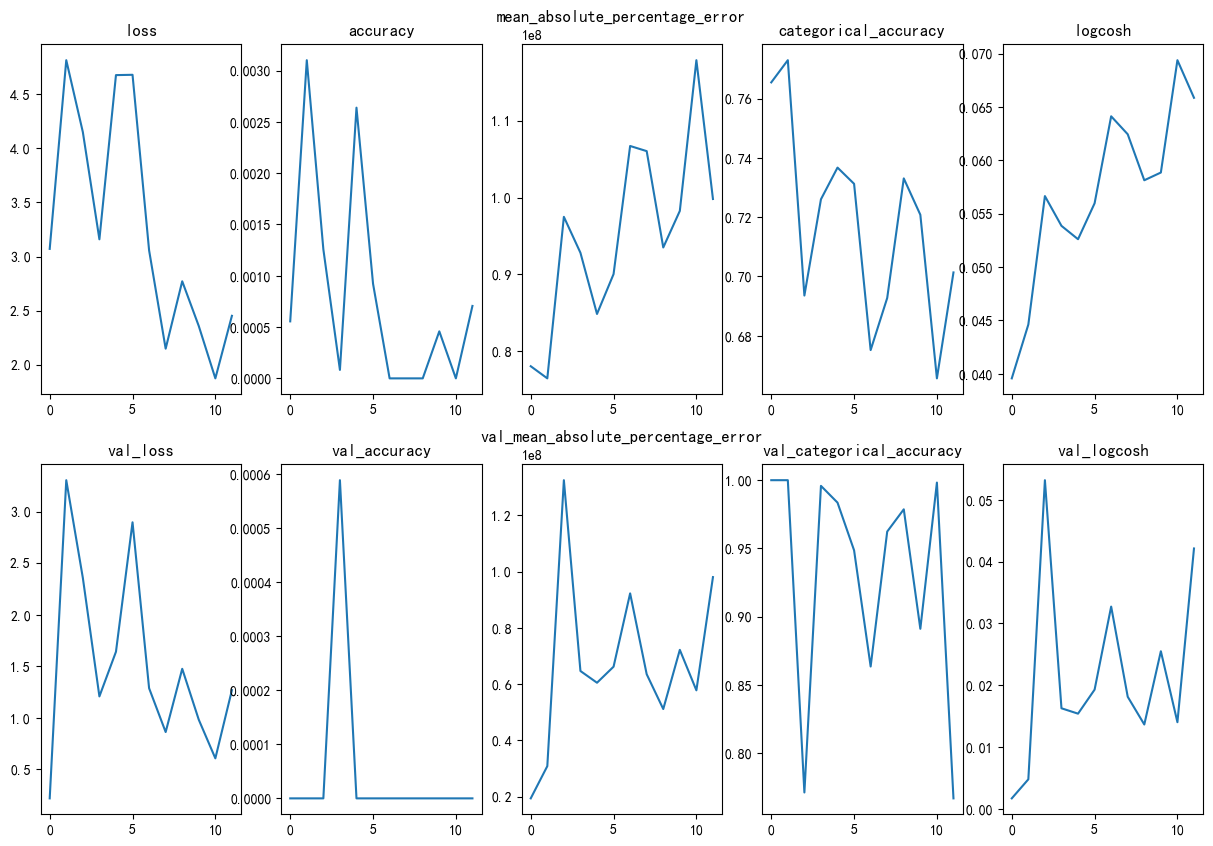

<Figure size 640x480 with 0 Axes>

In [16]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()
    plt.savefig(os.path.join(log_dir, 'learning_rate.png'))

plot_history_metrics(history)



In [17]:
# 保存模型结构及配置参数
model_json = model.to_json()
with open(os.path.join(log_dir,'model_json.json'),'w') as json_file:
    json_file.write(model_json)


In [18]:

# print(len(valWindow.repeat(1)))
for x,y in valWindow.repeat(1).take(1):
    print(x,y)

tf.Tensor(
[[[ 1.18706674  0.          1.56480449 ... -1.31967144  0.
    0.        ]
  [ 0.55980548  0.          1.11357277 ... -1.31967144  0.
    0.        ]
  [ 0.38499497  0.         -0.01704153 ... -1.31967144  0.
    0.        ]
  ...
  [ 2.10225119  0.          1.00203235 ... -0.87134658  0.
    0.        ]
  [ 1.18706674  0.          0.37841998 ... -1.31967144  0.
    0.        ]
  [ 0.50324914  0.         -0.01704153 ... -1.31967144  0.
    0.        ]]

 [[ 0.55980548  0.          1.11357277 ... -1.31967144  0.
    0.        ]
  [ 0.38499497  0.         -0.01704153 ... -1.31967144  0.
    0.        ]
  [ 0.50324914  0.          0.66234106 ... -0.87134658  0.
    0.        ]
  ...
  [ 1.18706674  0.          0.37841998 ... -1.31967144  0.
    0.        ]
  [ 0.50324914  0.         -0.01704153 ... -1.31967144  0.
    0.        ]
  [ 1.47498994  0.          0.88542191 ... -1.31967144  0.
    0.        ]]

 [[ 0.38499497  0.         -0.01704153 ... -1.31967144  0.
    0.        

In [19]:
#对模型在测试集上进行评估
valWindow=valWindow.prefetch(tf.data.AUTOTUNE)
metrics = model.evaluate(valWindow.repeat(1))
for name, value in zip(model.metrics_names, metrics):
    print(name, ': ', value)
# print("accuracy:", metrics[0], "accuracy:", metrics[1])


202/202 [==============================] - 2s 8ms/step - loss: 3.3045 - accuracy: 0.0000e+00 - mean_absolute_percentage_error: 30849162.0000 - categorical_accuracy: 1.0000 - logcosh: 0.0048
loss :  3.304506301879883
accuracy :  0.0
mean_absolute_percentage_error :  30849162.0
categorical_accuracy :  1.0
logcosh :  0.004766341298818588


2024-04-22 03:00:50.562037: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12781771931023823439
2024-04-22 03:00:50.562088: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13547584414703813050


In [20]:
predictions=model.predict(valWindow,verbose=1)
# predictions?

202/202 [==============================] - 1s 6ms/step


2024-04-22 03:00:51.880038: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5719153887757586582
2024-04-22 03:00:51.880072: I tensorflow/core/framework/local_rendezvous.cc:425] Local rendezvous send item cancelled. Key hash: 16126891847972944302


In [21]:
# 如果是多分类问题并且想比较类别概率分布
# 假设y_true和y_pred都是one-hot编码形式
# 可以选择几个样本画柱状图对比


y_true = valWindow.map(lambda x, y: v)
for i, v in enumerate(y_true):
    if i > 3:
        break
    
    print(v)
# print(predictions)
y_pred = tf.argmax(predictions)
# for i in y_pred:
#     # print(i)
#     # print(i)
#     e=1
# num_samples_to_plot = len(y_pred)
# nrows = 2
# plt.figure(figsize=(30, 6))
# plt.subplot(nrows, 1, 1)
# plt.plot(y_true, label='Actual values', linewidth=1.0)
# plt.subplot(nrows, 1, 2)
# plt.plot(y_pred, label='Predicted values', linewidth=1.0)
# plt.legend(fontsize=14)
# plt.xlabel('Sample Index')
# ax = plt.gca()
# ax.set_xlim(left=0, right=num_samples_to_plot)
# plt.ylabel('Value')
# plt.title('Actual vs Predicted Values Comparison')
# plt.grid(True)
# plt.show()
y_pred

NameError: in user code:

    File "/tmp/ipykernel_752/4038802009.py", line 6, in None  *
        lambda x, y: v

    NameError: name 'v' is not defined


In [ ]:
# # data.plot(legend=True, subplots=True, figsize=(30,30),  xlabel="steps")
# # ax = plt.gca()
# # ax.set_xlim(left=0, right=19000)


# # plt.show()
# times = df22[time_col_names].index.to_numpy()
# display(times)
# plt.plot(times, y, label="Actual", marker="o")
# plt.plot(times, predictions, label="Predicted", linestyle="--", marker="x")

# ax = plt.gca()
# ax.set_xlim(left=12000, right=18000)
# # 添加标题和标签
# plt.title("Actual vs. Predicted Values")
# plt.xlabel("Sample Index")
# plt.ylabel("Value")

# # 添加图例
# plt.legend()

# # 显示图形
# plt.show()

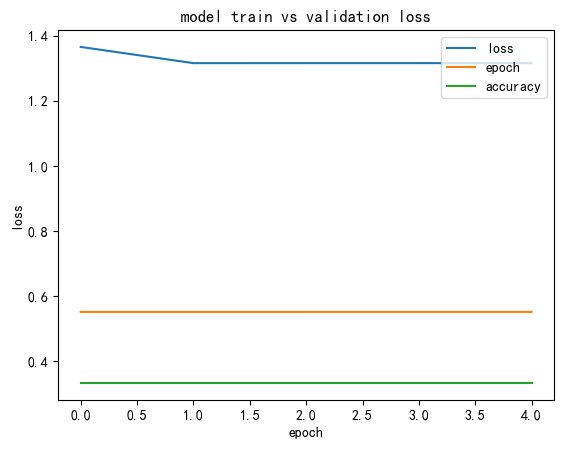

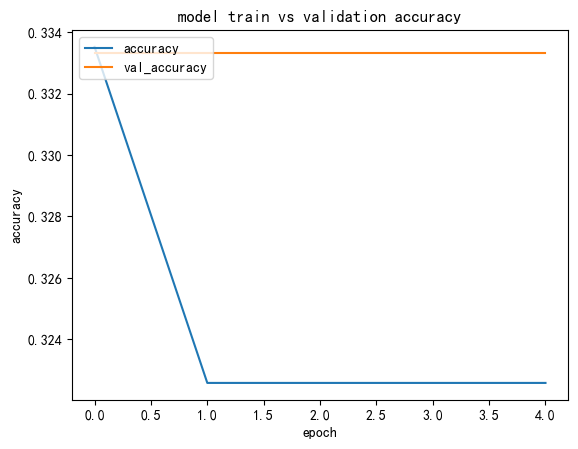

In [ ]:
# display(history.history)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["loss", "epoch", "accuracy"], loc="upper right")
plt.show()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model train vs validation accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["accuracy", "val_accuracy"], loc="upper left")
plt.show()

In [ ]:
display(df22.columns)

Index(['原始重量', '稳定重量', '轴重', 'su_ad', 'wpu_x', 'wpu_y', 'wpu_z', 'su_x',
       'su_y', 'su_z', '原始重量_diff', '稳定重量_diff', '轴重_diff', 'su_ad_diff',
       'wpu_x_diff', 'wpu_y_diff', 'wpu_z_diff', 'su_x_diff', 'su_y_diff',
       'su_z_diff', '速度', '估计重量', 'label', '时间', '轨迹时间'],
      dtype='object')

In [ ]:
# data22, scaler22 = normalize(df22, numeric_col_names)
# X22 = data22[feature_col_names]
# y_test22 =normalizeY( df22[label_col_names])
# x_train22  = np.asarray(X22) .reshape(-1, feature_col_num)
# predY22 = model.predict(x_train22, batch_size=batch_size)


# data23, scaler23 = normalize(df23, numeric_col_names)
# X23 = data23[feature_col_names]
# y_test23 =normalizeY( df23[label_col_names])
# x_train23  = np.asarray(X23) .reshape(-1, feature_col_num)
# predY23 = model.predict(x_train23, batch_size=batch_size)






# display(predY22,predY23)

In [ ]:
# fig_acc = plt.figure(figsize=(9, 9))
# plt.plot(predY23[0:27000])
# plt.plot(y_test23[0:27000])
# plt.title("real vs pred")
# plt.ylabel("value")
# plt.xlabel("epoch")
# plt.xlim((19000, 23000))
# plt.legend(["pred", "real"], loc="upper left")
# plt.show()